In [1]:
from __future__ import annotations

#os packages
import os
import itertools
import glob
import tempfile
import time
from pathlib import Path

#Data Packages
import numpy as np
import dask.array as da
import xarray as xr
xr.set_options(display_style="html")

#xarray parellel
from distributed import Client
Client()

import xclim as xc
import xclim.indices as xci


import pandas as pd

#Stats Packages

#Plotting Packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import AnchoredText
from matplotlib import gridspec, colors, colormaps, cm, ticker

# deprecated   import lcc_plotting_functs as lcc_pf     #.py file containing plotting functions for LCC gridline ticks

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cartopy.io.img_tiles as cimgt

from datetime import datetime, timedelta

#MPL inline magic
%matplotlib inline

# Output folder
output_folder = Path(tempfile.mkdtemp())

2023-08-28 22:49:13,715 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-k0z05ofb', purging
2023-08-28 22:49:13,715 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-cou9zdod', purging
2023-08-28 22:49:13,715 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-ymy752vh', purging
2023-08-28 22:49:13,716 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-11cx4hdz', purging
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xclim/indices/fire/_cffwis.py:217: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-usin

In [2]:
#set up a dask env. 
from distributed import Client

# Depending on your workstation specifications, you may need to adjust these values.
# On a single machine, n_workers=1 is usually better.
client = Client(n_workers=8, threads_per_worker=4, memory_limit="64GB") #mem limit * n_workers = total memory allocated
client

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41321 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:39132' processes=8 threads=32, memory=476.84 GiB>

In [3]:
# Path, you can do a lot with regex here to select what files to read in to begin with. 
#    For monthly the pattern is: *-01-* . ranges: *-0[1-3]-* (Jan 1 thru Mar 31) 
path0 = "/home/sleake/AFWA_TOTPRECIP_PrecipDays_hist/*0p254.nc"
#path = "/home/scratch/ahaberlie/AFWA_TOTPRECIP/end_of_century_8p5/*/*-07-*.nc"

files0 = glob.glob(path0, recursive=True)
files0.sort()
files_to_open0 = files0
print(f' Number of files in dataset {len(files_to_open0)}')

 Number of files in dataset 15


In [4]:
# Path, you can do a lot with regex here to select what files to read in to begin with. 
#    For monthly the pattern is: *-01-* . ranges: *-0[1-3]-* (Jan 1 thru Mar 31) 
path1 = "/home/sleake/AFWA_TOTPRECIP_PrecipDays_eoc_8p5/*0p254.nc"
#path = "/home/scratch/ahaberlie/AFWA_TOTPRECIP/end_of_century_8p5/*/*-07-*.nc"

files1 = glob.glob(path1, recursive=True)
files1.sort()
files_to_open1 = files1
print(f' Number of files in dataset {len(files_to_open1)}')

 Number of files in dataset 15


In [5]:
path_grid = r"/home/scratch/ahaberlie/simgeog"
grid = xr.open_dataset(os.path.join(path_grid,"geo_em.d01.nc"))

In [6]:
da0 = xr.open_mfdataset(files_to_open0,
                       chunks='auto',
                       combine='by_coords',
                       engine='netcdf4')
da0 = da0.assign_coords(lon=grid.CLONG[0], lat=grid.CLAT[0])

da0 = da0.rename({"Time":"time"})

In [7]:
da1 = xr.open_mfdataset(files_to_open1,
                       chunks='auto',
                       combine='by_coords',
                       engine='netcdf4')

da1 = da1.assign_coords(lon=grid.CLONG[0], lat=grid.CLAT[0])

da1 = da1.rename({"Time":"time"})

In [8]:
run_window = 5
run_season = [3,4,5]

In [9]:
def calculate_first_run_dataset(dataset, window=run_window, season=[1,2,3, 4, 5, 6, 7, 8, 9, 10, 11, 12]):
    # Calculate hydro years
    dataset['hydro_year'] = xr.where(dataset['time.month'] >= 10,
                                     dataset['time.year'] + 1,
                                     dataset['time.year'])

    # Group by hydro years
    grouped = dataset.groupby('hydro_year')

    # Calculate time values before applying xclim function
    time_values = [group.sel(time=group.time.dt.month.isin(season))['time'].values[0] for _, group in grouped]

    # Apply the first_run function to each group and stack the results
    first_run_results = []
    for hydro_year, group in grouped:
        group = group.sel(time=group.time.dt.month.isin(season)) #select March-May (inclusive)
        print(group)
        first_run = xci.run_length.first_run(~group.AFWA_TOTPRECIP, dim='time', coord='dayofyear', window=window) # input data is precip days, so we use the "~ group" to bitwise invert it to dry days
        first_run_results.append(first_run)

    # Combine the results into a new dataset
    da_first_run = xr.concat(first_run_results, dim='hydro_year')

    # Rename the 'hydro_year' dimension to 'time'
    da_first_run = da_first_run.rename({'hydro_year': 'time'})

    ## these should already be in DOY from the coord='dayofyear' argument in first_run
    # Convert the calculated time values to datetime64
    #time_values = np.array(time_values, dtype='datetime64[D]')

    # Assign the calculated time values to the 'time' coordinate
    da_first_run['time'] = time_values
    
    # Rename the variable from 'AFWA_TOTPRECIP' to 'AFWA_FIRST_RUN_DAY'
    #ds_first_run = ds_first_run.rename_vars({'AFWA_TOTPRECIP': 'AFWA_FIRST_RUN_DAY'})

    return da_first_run

In [10]:
da0_first_runs = calculate_first_run_dataset(da0, window=run_window, season=run_season)
da0_first_runs

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.Dataset>
Dimensions:         (south_north: 899, west_east: 1399, time: 92)
Coordinates:
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
  * time            (time) datetime64[ns] 1991-03-01T12:00:00 ... 1991-05-31T...
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (time, south_north, west_east) bool dask.array<chunksize=(91, 596, 928), meta=np.ndarray>
    hydro_year      (time) int64 1991 1991 1991 1991 ... 1991 1991 1991 1991
Attributes: (12/87)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      1990-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:     

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/distributed/worker.py:2845: UserWarning: Large object of size 2.11 MiB detected in task graph: 
  ([('south_north', 'west_east'), <xarray.Variable ( ... , 'sr_y': 1}],)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(value

<xarray.Dataset>
Dimensions:         (south_north: 899, west_east: 1399, time: 92)
Coordinates:
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
  * time            (time) datetime64[ns] 1992-03-01T12:00:00 ... 1992-05-31T...
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (time, south_north, west_east) bool dask.array<chunksize=(31, 596, 928), meta=np.ndarray>
    hydro_year      (time) int64 1992 1992 1992 1992 ... 1992 1992 1992 1992
Attributes: (12/87)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      1990-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:     

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.Dataset>
Dimensions:         (south_north: 899, west_east: 1399, time: 92)
Coordinates:
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
  * time            (time) datetime64[ns] 1993-03-01T12:00:00 ... 1993-05-31T...
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (time, south_north, west_east) bool dask.array<chunksize=(91, 596, 928), meta=np.ndarray>
    hydro_year      (time) int64 1993 1993 1993 1993 ... 1993 1993 1993 1993
Attributes: (12/87)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      1990-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:     

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.Dataset>
Dimensions:         (south_north: 899, west_east: 1399, time: 92)
Coordinates:
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
  * time            (time) datetime64[ns] 1994-03-01T12:00:00 ... 1994-05-31T...
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (time, south_north, west_east) bool dask.array<chunksize=(91, 596, 928), meta=np.ndarray>
    hydro_year      (time) int64 1994 1994 1994 1994 ... 1994 1994 1994 1994
Attributes: (12/87)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      1990-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:     

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.Dataset>
Dimensions:         (south_north: 899, west_east: 1399, time: 92)
Coordinates:
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
  * time            (time) datetime64[ns] 1995-03-01T12:00:00 ... 1995-05-31T...
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (time, south_north, west_east) bool dask.array<chunksize=(91, 596, 928), meta=np.ndarray>
    hydro_year      (time) int64 1995 1995 1995 1995 ... 1995 1995 1995 1995
Attributes: (12/87)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      1990-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:     

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.Dataset>
Dimensions:         (south_north: 899, west_east: 1399, time: 92)
Coordinates:
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
  * time            (time) datetime64[ns] 1996-03-01T12:00:00 ... 1996-05-31T...
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (time, south_north, west_east) bool dask.array<chunksize=(31, 596, 928), meta=np.ndarray>
    hydro_year      (time) int64 1996 1996 1996 1996 ... 1996 1996 1996 1996
Attributes: (12/87)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      1990-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:     

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.Dataset>
Dimensions:         (south_north: 899, west_east: 1399, time: 92)
Coordinates:
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
  * time            (time) datetime64[ns] 1997-03-01T12:00:00 ... 1997-05-31T...
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (time, south_north, west_east) bool dask.array<chunksize=(91, 596, 928), meta=np.ndarray>
    hydro_year      (time) int64 1997 1997 1997 1997 ... 1997 1997 1997 1997
Attributes: (12/87)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      1990-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:     

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.Dataset>
Dimensions:         (south_north: 899, west_east: 1399, time: 92)
Coordinates:
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
  * time            (time) datetime64[ns] 1998-03-01T12:00:00 ... 1998-05-31T...
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (time, south_north, west_east) bool dask.array<chunksize=(91, 596, 928), meta=np.ndarray>
    hydro_year      (time) int64 1998 1998 1998 1998 ... 1998 1998 1998 1998
Attributes: (12/87)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      1990-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:     

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.Dataset>
Dimensions:         (south_north: 899, west_east: 1399, time: 92)
Coordinates:
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
  * time            (time) datetime64[ns] 1999-03-01T12:00:00 ... 1999-05-31T...
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (time, south_north, west_east) bool dask.array<chunksize=(91, 596, 928), meta=np.ndarray>
    hydro_year      (time) int64 1999 1999 1999 1999 ... 1999 1999 1999 1999
Attributes: (12/87)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      1990-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:     

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.Dataset>
Dimensions:         (south_north: 899, west_east: 1399, time: 92)
Coordinates:
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
  * time            (time) datetime64[ns] 2000-03-01T12:00:00 ... 2000-05-31T...
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (time, south_north, west_east) bool dask.array<chunksize=(31, 596, 928), meta=np.ndarray>
    hydro_year      (time) int64 2000 2000 2000 2000 ... 2000 2000 2000 2000
Attributes: (12/87)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      1990-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:     

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.Dataset>
Dimensions:         (south_north: 899, west_east: 1399, time: 92)
Coordinates:
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
  * time            (time) datetime64[ns] 2001-03-01T12:00:00 ... 2001-05-31T...
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (time, south_north, west_east) bool dask.array<chunksize=(91, 596, 928), meta=np.ndarray>
    hydro_year      (time) int64 2001 2001 2001 2001 ... 2001 2001 2001 2001
Attributes: (12/87)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      1990-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:     

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.Dataset>
Dimensions:         (south_north: 899, west_east: 1399, time: 92)
Coordinates:
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
  * time            (time) datetime64[ns] 2002-03-01T12:00:00 ... 2002-05-31T...
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (time, south_north, west_east) bool dask.array<chunksize=(91, 596, 928), meta=np.ndarray>
    hydro_year      (time) int64 2002 2002 2002 2002 ... 2002 2002 2002 2002
Attributes: (12/87)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      1990-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:     

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.Dataset>
Dimensions:         (south_north: 899, west_east: 1399, time: 92)
Coordinates:
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
  * time            (time) datetime64[ns] 2003-03-01T12:00:00 ... 2003-05-31T...
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (time, south_north, west_east) bool dask.array<chunksize=(91, 596, 928), meta=np.ndarray>
    hydro_year      (time) int64 2003 2003 2003 2003 ... 2003 2003 2003 2003
Attributes: (12/87)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      1990-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:     

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.Dataset>
Dimensions:         (south_north: 899, west_east: 1399, time: 92)
Coordinates:
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
  * time            (time) datetime64[ns] 2004-03-01T12:00:00 ... 2004-05-31T...
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (time, south_north, west_east) bool dask.array<chunksize=(31, 596, 928), meta=np.ndarray>
    hydro_year      (time) int64 2004 2004 2004 2004 ... 2004 2004 2004 2004
Attributes: (12/87)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      1990-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:     

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.Dataset>
Dimensions:         (south_north: 899, west_east: 1399, time: 92)
Coordinates:
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
  * time            (time) datetime64[ns] 2005-03-01T12:00:00 ... 2005-05-31T...
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (time, south_north, west_east) bool dask.array<chunksize=(31, 596, 928), meta=np.ndarray>
    hydro_year      (time) int64 2005 2005 2005 2005 ... 2005 2005 2005 2005
Attributes: (12/87)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      1990-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:     

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.DataArray 'dayofyear' (time: 15, south_north: 899, west_east: 1399)>
dask.array<concatenate, shape=(15, 899, 1399), dtype=float64, chunksize=(1, 596, 928), chunktype=numpy.ndarray>
Coordinates:
    lon      (south_north, west_east) float32 -121.8 -121.8 ... -61.38 -61.34
    lat      (south_north, west_east) float32 20.51 20.52 20.53 ... 48.91 48.89
  * time     (time) datetime64[ns] 1991-03-01T12:00:00 ... 2005-03-01T12:00:00
Dimensions without coordinates: south_north, west_east

In [11]:
da1_first_runs = calculate_first_run_dataset(da1, window=run_window, season=run_season)
da1_first_runs

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.Dataset>
Dimensions:         (south_north: 899, west_east: 1399, time: 92)
Coordinates:
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
  * time            (time) datetime64[ns] 2086-03-01T12:00:00 ... 2086-05-31T...
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (time, south_north, west_east) bool dask.array<chunksize=(91, 596, 928), meta=np.ndarray>
    hydro_year      (time) int64 2086 2086 2086 2086 ... 2086 2086 2086 2086
Attributes: (12/87)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      2085-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:     

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.Dataset>
Dimensions:         (south_north: 899, west_east: 1399, time: 92)
Coordinates:
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
  * time            (time) datetime64[ns] 2087-03-01T12:00:00 ... 2087-05-31T...
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (time, south_north, west_east) bool dask.array<chunksize=(91, 596, 928), meta=np.ndarray>
    hydro_year      (time) int64 2087 2087 2087 2087 ... 2087 2087 2087 2087
Attributes: (12/87)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      2085-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:     

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.Dataset>
Dimensions:         (south_north: 899, west_east: 1399, time: 92)
Coordinates:
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
  * time            (time) datetime64[ns] 2088-03-01T12:00:00 ... 2088-05-31T...
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (time, south_north, west_east) bool dask.array<chunksize=(31, 596, 928), meta=np.ndarray>
    hydro_year      (time) int64 2088 2088 2088 2088 ... 2088 2088 2088 2088
Attributes: (12/87)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      2085-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:     

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.Dataset>
Dimensions:         (south_north: 899, west_east: 1399, time: 92)
Coordinates:
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
  * time            (time) datetime64[ns] 2089-03-01T12:00:00 ... 2089-05-31T...
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (time, south_north, west_east) bool dask.array<chunksize=(91, 596, 928), meta=np.ndarray>
    hydro_year      (time) int64 2089 2089 2089 2089 ... 2089 2089 2089 2089
Attributes: (12/87)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      2085-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:     

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.Dataset>
Dimensions:         (south_north: 899, west_east: 1399, time: 92)
Coordinates:
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
  * time            (time) datetime64[ns] 2090-03-01T12:00:00 ... 2090-05-31T...
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (time, south_north, west_east) bool dask.array<chunksize=(91, 596, 928), meta=np.ndarray>
    hydro_year      (time) int64 2090 2090 2090 2090 ... 2090 2090 2090 2090
Attributes: (12/87)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      2085-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:     

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.Dataset>
Dimensions:         (south_north: 899, west_east: 1399, time: 92)
Coordinates:
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
  * time            (time) datetime64[ns] 2091-03-01T12:00:00 ... 2091-05-31T...
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (time, south_north, west_east) bool dask.array<chunksize=(91, 596, 928), meta=np.ndarray>
    hydro_year      (time) int64 2091 2091 2091 2091 ... 2091 2091 2091 2091
Attributes: (12/87)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      2085-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:     

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.Dataset>
Dimensions:         (south_north: 899, west_east: 1399, time: 92)
Coordinates:
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
  * time            (time) datetime64[ns] 2092-03-01T12:00:00 ... 2092-05-31T...
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (time, south_north, west_east) bool dask.array<chunksize=(31, 596, 928), meta=np.ndarray>
    hydro_year      (time) int64 2092 2092 2092 2092 ... 2092 2092 2092 2092
Attributes: (12/87)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      2085-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:     

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.Dataset>
Dimensions:         (south_north: 899, west_east: 1399, time: 92)
Coordinates:
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
  * time            (time) datetime64[ns] 2093-03-01T12:00:00 ... 2093-05-31T...
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (time, south_north, west_east) bool dask.array<chunksize=(91, 596, 928), meta=np.ndarray>
    hydro_year      (time) int64 2093 2093 2093 2093 ... 2093 2093 2093 2093
Attributes: (12/87)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      2085-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:     

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.Dataset>
Dimensions:         (south_north: 899, west_east: 1399, time: 92)
Coordinates:
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
  * time            (time) datetime64[ns] 2094-03-01T12:00:00 ... 2094-05-31T...
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (time, south_north, west_east) bool dask.array<chunksize=(91, 596, 928), meta=np.ndarray>
    hydro_year      (time) int64 2094 2094 2094 2094 ... 2094 2094 2094 2094
Attributes: (12/87)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      2085-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:     

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.Dataset>
Dimensions:         (south_north: 899, west_east: 1399, time: 92)
Coordinates:
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
  * time            (time) datetime64[ns] 2095-03-01T12:00:00 ... 2095-05-31T...
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (time, south_north, west_east) bool dask.array<chunksize=(91, 596, 928), meta=np.ndarray>
    hydro_year      (time) int64 2095 2095 2095 2095 ... 2095 2095 2095 2095
Attributes: (12/87)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      2085-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:     

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.Dataset>
Dimensions:         (south_north: 899, west_east: 1399, time: 92)
Coordinates:
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
  * time            (time) datetime64[ns] 2096-03-01T12:00:00 ... 2096-05-31T...
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (time, south_north, west_east) bool dask.array<chunksize=(31, 596, 928), meta=np.ndarray>
    hydro_year      (time) int64 2096 2096 2096 2096 ... 2096 2096 2096 2096
Attributes: (12/87)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      2085-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:     

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.Dataset>
Dimensions:         (south_north: 899, west_east: 1399, time: 92)
Coordinates:
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
  * time            (time) datetime64[ns] 2097-03-01T12:00:00 ... 2097-05-31T...
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (time, south_north, west_east) bool dask.array<chunksize=(91, 596, 928), meta=np.ndarray>
    hydro_year      (time) int64 2097 2097 2097 2097 ... 2097 2097 2097 2097
Attributes: (12/87)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      2085-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:     

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.Dataset>
Dimensions:         (south_north: 899, west_east: 1399, time: 92)
Coordinates:
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
  * time            (time) datetime64[ns] 2098-03-01T12:00:00 ... 2098-05-31T...
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (time, south_north, west_east) bool dask.array<chunksize=(91, 596, 928), meta=np.ndarray>
    hydro_year      (time) int64 2098 2098 2098 2098 ... 2098 2098 2098 2098
Attributes: (12/87)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      2085-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:     

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.Dataset>
Dimensions:         (south_north: 899, west_east: 1399, time: 92)
Coordinates:
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
  * time            (time) datetime64[ns] 2099-03-01T12:00:00 ... 2099-05-31T...
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (time, south_north, west_east) bool dask.array<chunksize=(91, 596, 928), meta=np.ndarray>
    hydro_year      (time) int64 2099 2099 2099 2099 ... 2099 2099 2099 2099
Attributes: (12/87)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      2085-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:     

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.Dataset>
Dimensions:         (south_north: 899, west_east: 1399, time: 92)
Coordinates:
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
  * time            (time) datetime64[ns] 2100-03-01T12:00:00 ... 2100-05-31T...
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (time, south_north, west_east) bool dask.array<chunksize=(31, 596, 928), meta=np.ndarray>
    hydro_year      (time) int64 2100 2100 2100 2100 ... 2100 2100 2100 2100
Attributes: (12/87)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      2085-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:     

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.DataArray 'dayofyear' (time: 15, south_north: 899, west_east: 1399)>
dask.array<concatenate, shape=(15, 899, 1399), dtype=float64, chunksize=(1, 596, 928), chunktype=numpy.ndarray>
Coordinates:
    lon      (south_north, west_east) float32 -121.8 -121.8 ... -61.38 -61.34
    lat      (south_north, west_east) float32 20.51 20.52 20.53 ... 48.91 48.89
  * time     (time) datetime64[ns] 2086-03-01T12:00:00 ... 2100-03-01T12:00:00
Dimensions without coordinates: south_north, west_east

In [12]:
def calculate_angular_mean_vectorized(day_of_year_values):
    # Mask NaN values
    mask = np.isnan(day_of_year_values)
    valid_values = day_of_year_values[~mask]

    if len(valid_values) == 0:
        # All values are NaN, return NaN
        return np.nan

    # Convert day of year to angles on unit circle
    angles = (valid_values - 1) * 2 * np.pi / 365

    # Calculate circular mean of angles
    circular_mean_angle = np.angle(np.mean(np.exp(1j * angles)))

    # Convert mean angle back to day of year
    mean_day_of_year = (circular_mean_angle * 365 / (2 * np.pi)) + 1

    return mean_day_of_year

def calculate_angular_mean_dataarray(input_da):
    # Extract the variable
    #var = input_ds[variable_name]

    # Rechunk the 'time' dimension into a single chunk
    var_rechunked = input_da.chunk({'time': -1})

    # Apply the vectorized function to the rechunked variable using .apply_ufunc()
    mean_day_of_year = xr.apply_ufunc(
        calculate_angular_mean_vectorized,
        var_rechunked,
        input_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float]
    )

    # Create a new DataArray with the calculated mean and coordinates from the input dataset
    mean_da = xr.DataArray(
        mean_day_of_year,
        coords={
            'lon': input_da['lon'],
            'lat': input_da['lat']
        },
        dims=['south_north', 'west_east']
    )

    return mean_da


In [14]:
# Calculate the mean day of year and create a new dataset
mean_day_of_year0 = calculate_angular_mean_dataarray(da0_first_runs)

# Calculate the mean day of year and create a new dataset
mean_day_of_year1 = calculate_angular_mean_dataarray(da1_first_runs)

In [15]:
mean_day_of_year_dep = mean_day_of_year1-mean_day_of_year0

/tmp/ipykernel_20273/2799699213.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('PuOr', c_bins) #We can add discrete levels by specifying a <cmap>,<#of levs>)


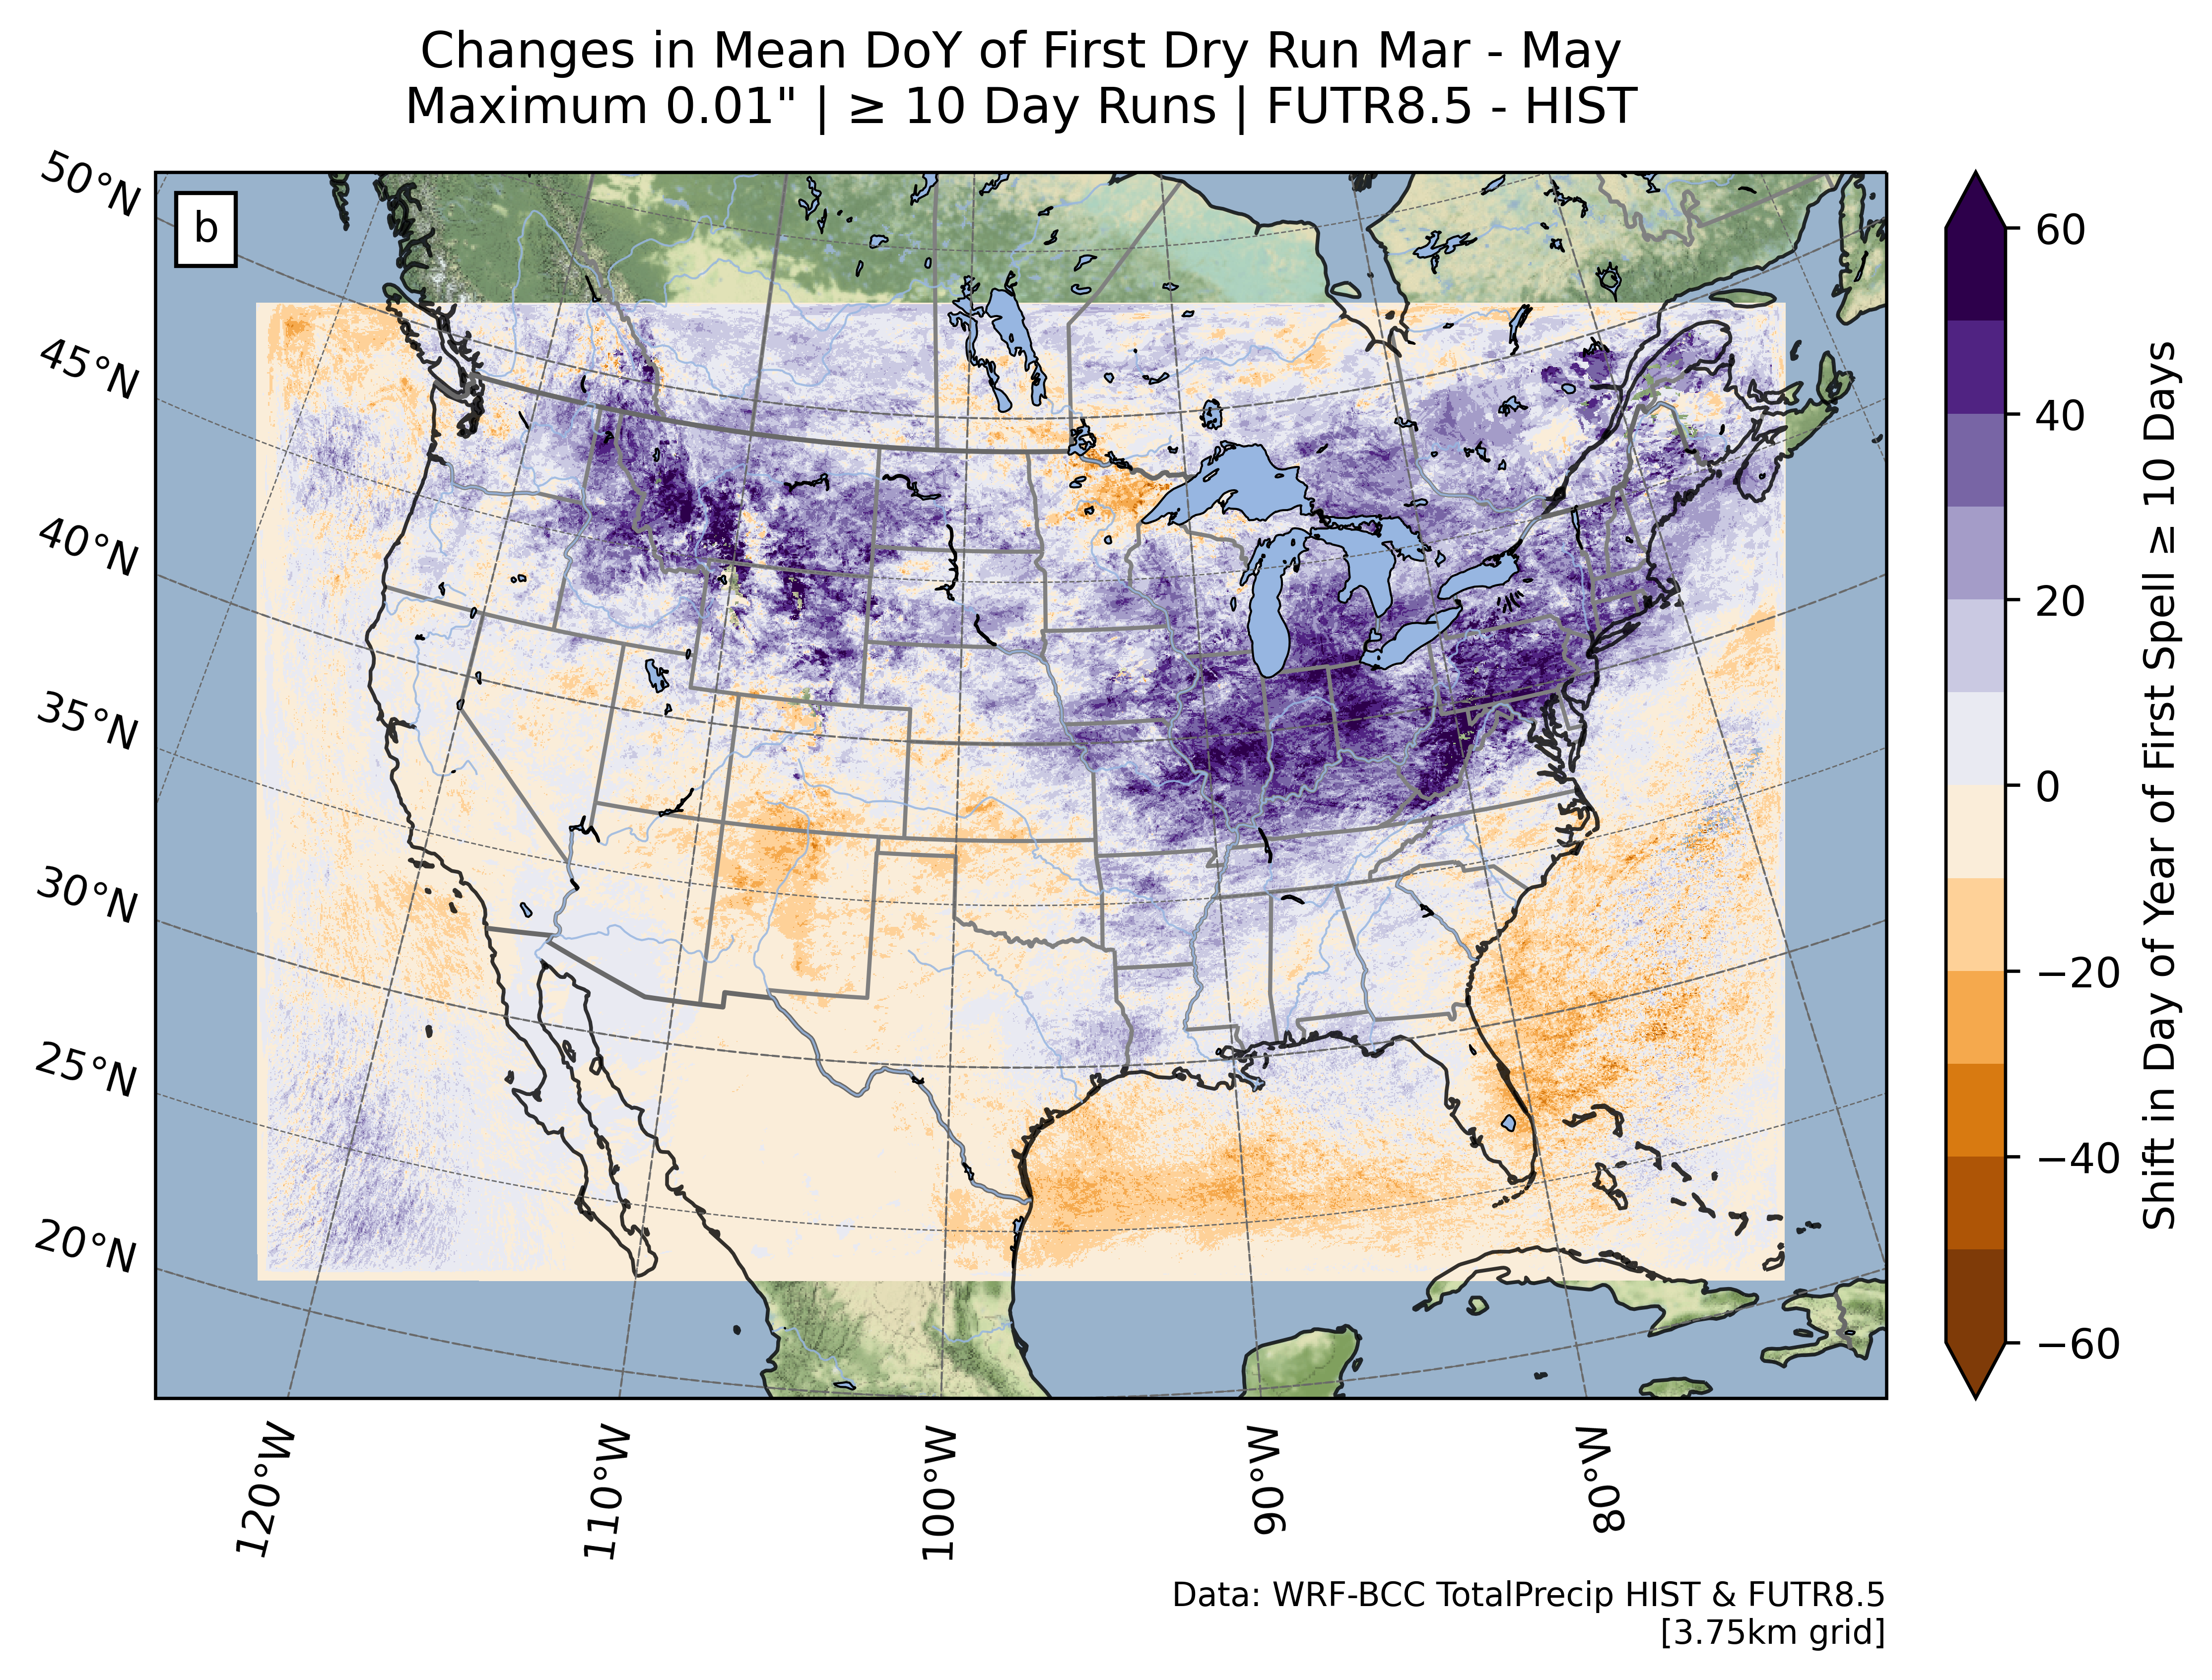

In [16]:
#plot as a mesh in its own fig for now until it can be integrated back into xarray 
months_dict = {1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"}
#plt.imshow(precip_runs_constr_fr_data)#, extent=[min_lon, max_lon, min_lat, min_lon])
#plt.show()

#fig, (ax0, ax1) = plt.subplots(nrows=2)

x=mean_day_of_year_dep.coords['lon']
y=mean_day_of_year_dep.coords['lat']
z=mean_day_of_year_dep

#print(x.shape)
#print(y.shape)
#print(z.shape)

#mesh = ax0.pcolormesh(x=precip_runs_constr_fr.coords['lon'],
#                      y=precip_runs_constr_fr.coords['lat'],
#                      z=precip_runs_constr_fr_data,
#                      shading='auto',
#                      xlim=[min_lon - .5, max_lon + .5],
#                      ylim=[min_lat - .5, max_lat + .5],
#                      #norm=colors.LogNorm(vmin=0.000001, clip=True),
#                     )

#wont work cause of calling this on a np array. need to convert to a data array
#mesh = precip_runs_constr_fr.AFWA_TOTPRECIP_FIRST_RUN.pcolormesh(x=precip_runs_constr_fr.coords['lon'],
#                                                                      y=precip_runs_constr_fr.coords['lon'],
#                                             xlim=[min_lon - .5, max_lon + .5],
#                                             ylim=[min_lat - .5, max_lat + .5],
#                                             #norm=colors.LogNorm(vmin=0.000001, clip=True),
#                                            )


#create plot
gs  = gridspec.GridSpec(2,3, width_ratios=[5, 5, 10], 
                       height_ratios=[5,5],
                       top = 0.75,
                       bottom = 0.1,
                       wspace = 0.5,
                       hspace = 0.5)

fig = plt.figure(figsize=(20, 10), frameon=True, dpi=600.0)

#Full extent: 
negXLim, posXLim, negYLim, posYLim= -125., -70., 20., 55.
#Clipped:
#negXLim, posXLim, negYLim, posYLim= -92.5, -82.5, 45., 55.

extent = [negXLim, posXLim, negYLim, posYLim]
c_bins = 12
cmap = cm.get_cmap('PuOr', c_bins) #We can add discrete levels by specifying a <cmap>,<#of levs>)

p = ccrs.LambertConformal(central_longitude=262.5, central_latitude=38.5, standard_parallels=(38.5, 38.5))
ax0 = fig.add_subplot(gs[:,2], projection=p)
ax0.set_extent(extent, crs=ccrs.PlateCarree())
#ax0.stock_img()  # oceans/land basemap
# Create a Stamen terrain background instance.
stamen_terrain = cimgt.Stamen('terrain-background')
ax0.add_image(stamen_terrain, 6, zorder=1)
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax0.add_feature(states_provinces, edgecolor='gray', lw=1., zorder=2)
ax0.add_feature(cfeature.OCEAN, zorder=0)
ax0.add_feature(cfeature.COASTLINE, edgecolor='k', lw=.9, alpha=0.8, zorder=2)
ax0.add_feature(cfeature.BORDERS, edgecolor='dimgray', lw=1.2, zorder=2)
ax0.add_feature(cfeature.RIVERS, lw=.5, alpha=.85, zorder=2)
ax0.add_feature(cfeature.LAKES, edgecolor='k', lw=.5, zorder=2)

# *must* call canvas.draw in order to get the axis boundary used to add ticks:
fig.canvas.draw()
xticks = list(np.arange(-120, -60, 10))
yticks = list(np.arange(20, 60, 10))
ax0.gridlines(xlocs=xticks, ylocs=yticks, lw=.5, color='dimgray', linestyle='--', zorder=2)


# plot the actual data
#precip_at_time
'''mesh = precip_runs_constr_x.plot.pcolormesh(x='lon', y='lat',
                                            transform=ccrs.PlateCarree(),
                                            ax=0,
                                            cmap=cmap,
                                            shading='auto',
                                            zorder=3
                                             #xlim=[min_lon - .5, max_lon + .5],
                                             #ylim=[min_lat - .5, max_lat + .5],
                                             #norm=colors.LogNorm(vmin=0.000001, clip=True),
                                            )
'''
mesh = ax0.pcolormesh(x, y, z,
                                      cmap=cmap,
                                      transform=ccrs.PlateCarree(),
                                      shading='auto',
                                      vmin=-60,#1., 
                                      vmax=60,#365.,
                                      #norm=colors.LogNorm(vmin=0.1, vmax=100, clip=True),
                                      #alpha=.5,    # be careful with alpha, as c_bar is on a white background
                                      #add_labels=True,
                                      zorder=1)

ax0.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax0.yaxis.set_major_formatter(LATITUDE_FORMATTER)
#lcc_pf.lambert_xticks(ax0, xticks)
#lcc_pf.lambert_yticks(ax0, yticks)
gl = ax0.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.33, color='dimgray', linestyle='--')
gl.right_labels = gl.top_labels = False
gl.ylocator = ticker.AutoLocator()#FixedLocator([25,30,35,40, 45, 50])
gl.xlocator = ticker.AutoLocator()#FixedLocator([-100, -95, -90, -85, -80, -75, -70])

#ax0 titles, text, labels, etc
ax0.title.set_text(f'Changes in Mean DoY of First Dry Run {str(months_dict[run_season[0]]) + " - " + str(months_dict[run_season[-1]]) if len(run_season) < 12 else ""}\
\nMaximum 0.01" | ≥ {run_window} Day Runs | FUTR8.5 - HIST')

ax0.set_xlabel("")  # X & Y shouldn't need lables in this context, just lat and lon
ax0.set_ylabel("")
anchored_text = AnchoredText("a", loc=2)
ax0.add_artist(anchored_text)
ax0.text(1.,-0.2, "Data: WRF-BCC TotalPrecip HIST & FUTR8.5\n[3.75km grid]",
         size=8, ha="right", 
         transform=ax0.transAxes)

# if you wanted to subset for visulization without adjusting axes extent, could be a non rect. patch as well
#patch = patches.Rectangle((negXLim, negYLim), 
#                          posXLim-negXLim, 
#                          posYLim-negYLim,  
#                          transform = ax0.transData)     
#ax0.pcolormesh(lons[400:1200,1400:1600], lats[400:1200,1400:1600], data[400:1200,1400:1600],
#               cmap = plt.get_cmap('jet'), vmin=0, vmax=50)#,
#              #clip_path=patch)

#add our colorbar for all axes
# rect that defines cbar if we pass cax=cax parameter to fig.colorbar
# we cannot use the divide trick for 'mpl simple colorbar' to subvdivide a geo axis
ax0_lims=ax0.get_position()       #https://matplotlib.org/3.1.1/api/transformations.html#matplotlib.transforms.BboxBase
cax = fig.add_axes((0.91, ax0_lims.corners()[0,1], 0.01, ax0_lims.height))    #set lims to (bottom corner x, bottom corner y(from ax0 plot), width, height(ax0 height))
#cmap.set_over("red")
color_bar = fig.colorbar(mesh, cax=cax, extend='both')
color_bar.set_label(f'Shift in Day of Year of First Spell ≥ {run_window} Days', labelpad=5, fontsize=10) #neg vals move labelpad left (pixels)
#color_bar.ax.locator_params(nbins=c_bins)

In [ ]:
#plot as a mesh in its own fig for now until it can be integrated back into xarray 
months_dict = {1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"}
#plt.imshow(precip_runs_constr_fr_data)#, extent=[min_lon, max_lon, min_lat, min_lon])
#plt.show()

#fig, (ax0, ax1) = plt.subplots(nrows=2)

x=mean_day_of_year0.coords['lon']
y=mean_day_of_year0.coords['lat']
z=mean_day_of_year0

#print(x.shape)
#print(y.shape)
#print(z.shape)

#mesh = ax0.pcolormesh(x=precip_runs_constr_fr.coords['lon'],
#                      y=precip_runs_constr_fr.coords['lat'],
#                      z=precip_runs_constr_fr_data,
#                      shading='auto',
#                      xlim=[min_lon - .5, max_lon + .5],
#                      ylim=[min_lat - .5, max_lat + .5],
#                      #norm=colors.LogNorm(vmin=0.000001, clip=True),
#                     )

#wont work cause of calling this on a np array. need to convert to a data array
#mesh = precip_runs_constr_fr.AFWA_TOTPRECIP_FIRST_RUN.pcolormesh(x=precip_runs_constr_fr.coords['lon'],
#                                                                      y=precip_runs_constr_fr.coords['lon'],
#                                             xlim=[min_lon - .5, max_lon + .5],
#                                             ylim=[min_lat - .5, max_lat + .5],
#                                             #norm=colors.LogNorm(vmin=0.000001, clip=True),
#                                            )


#create plot
gs  = gridspec.GridSpec(2,3, width_ratios=[5, 5, 10], 
                       height_ratios=[5,5],
                       top = 0.75,
                       bottom = 0.1,
                       wspace = 0.5,
                       hspace = 0.5)

fig = plt.figure(figsize=(20, 10), frameon=True, dpi=600.0)

#Full extent: 
negXLim, posXLim, negYLim, posYLim= -125., -70., 20., 55.
#Clipped:
#negXLim, posXLim, negYLim, posYLim= -92.5, -82.5, 45., 55.

extent = [negXLim, posXLim, negYLim, posYLim]
#c_bins = 12
cmap = cm.get_cmap('twilight_shifted') #We can add discrete levels by specifying a <cmap>,<#of levs>) #We can add discrete levels by specifying a <cmap>,<#of levs>)

p = ccrs.LambertConformal(central_longitude=262.5, central_latitude=38.5, standard_parallels=(38.5, 38.5))
ax0 = fig.add_subplot(gs[:,2], projection=p)
ax0.set_extent(extent, crs=ccrs.PlateCarree())
#ax0.stock_img()  # oceans/land basemap
# Create a Stamen terrain background instance.
stamen_terrain = cimgt.Stamen('terrain-background')
ax0.add_image(stamen_terrain, 6, zorder=1)
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax0.add_feature(states_provinces, edgecolor='gray', lw=1., zorder=2)
ax0.add_feature(cfeature.OCEAN, zorder=0)
ax0.add_feature(cfeature.COASTLINE, edgecolor='k', lw=.9, alpha=0.8, zorder=2)
ax0.add_feature(cfeature.BORDERS, edgecolor='dimgray', lw=1.2, zorder=2)
ax0.add_feature(cfeature.RIVERS, lw=.5, alpha=.85, zorder=2)
ax0.add_feature(cfeature.LAKES, edgecolor='k', lw=.5, zorder=2)

# *must* call canvas.draw in order to get the axis boundary used to add ticks:
fig.canvas.draw()
xticks = list(np.arange(-120, -60, 10))
yticks = list(np.arange(20, 60, 10))
ax0.gridlines(xlocs=xticks, ylocs=yticks, lw=.5, color='dimgray', linestyle='--', zorder=2)


# plot the actual data
#precip_at_time
'''mesh = precip_runs_constr_x.plot.pcolormesh(x='lon', y='lat',
                                            transform=ccrs.PlateCarree(),
                                            ax=0,
                                            cmap=cmap,
                                            shading='auto',
                                            zorder=3
                                             #xlim=[min_lon - .5, max_lon + .5],
                                             #ylim=[min_lat - .5, max_lat + .5],
                                             #norm=colors.LogNorm(vmin=0.000001, clip=True),
                                            )
'''
mesh = ax0.pcolormesh(x, y, z,
                                      cmap=cmap,
                                      transform=ccrs.PlateCarree(),
                                      shading='auto',
                                      vmin=1., 
                                      vmax=365.,
                                      #norm=colors.LogNorm(vmin=0.1, vmax=100, clip=True),
                                      #alpha=.5,    # be careful with alpha, as c_bar is on a white background
                                      #add_labels=True,
                                      zorder=1)

ax0.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax0.yaxis.set_major_formatter(LATITUDE_FORMATTER)
#lcc_pf.lambert_xticks(ax0, xticks)
#lcc_pf.lambert_yticks(ax0, yticks)
gl = ax0.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.33, color='dimgray', linestyle='--')
gl.right_labels = gl.top_labels = False
gl.ylocator = ticker.AutoLocator()#FixedLocator([25,30,35,40, 45, 50])
gl.xlocator = ticker.AutoLocator()#FixedLocator([-100, -95, -90, -85, -80, -75, -70])

#ax0 titles, text, labels, etc
ax0.title.set_text(f'Mean DoY of First Dry Run {str(months_dict[run_season[0]]) + " - " + str(months_dict[run_season[-1]]) if len(run_season) < 12 else ""}\
\nMaximum 0.01" | ≥ {run_window} Day Runs | HIST')

ax0.set_xlabel("")  # X & Y shouldn't need lables in this context, just lat and lon
ax0.set_ylabel("")
anchored_text = AnchoredText("a", loc=2)
ax0.add_artist(anchored_text)
ax0.text(1.,-0.2, "Data: WRF-BCC TotalPrecip HIST\n[3.75km grid]",
         size=8, ha="right", 
         transform=ax0.transAxes)

# if you wanted to subset for visulization without adjusting axes extent, could be a non rect. patch as well
#patch = patches.Rectangle((negXLim, negYLim), 
#                          posXLim-negXLim, 
#                          posYLim-negYLim,  
#                          transform = ax0.transData)     
#ax0.pcolormesh(lons[400:1200,1400:1600], lats[400:1200,1400:1600], data[400:1200,1400:1600],
#               cmap = plt.get_cmap('jet'), vmin=0, vmax=50)#,
#              #clip_path=patch)

#add our colorbar for all axes
# rect that defines cbar if we pass cax=cax parameter to fig.colorbar
# we cannot use the divide trick for 'mpl simple colorbar' to subvdivide a geo axis
ax0_lims=ax0.get_position()       #https://matplotlib.org/3.1.1/api/transformations.html#matplotlib.transforms.BboxBase
cax = fig.add_axes((0.91, ax0_lims.corners()[0,1], 0.01, ax0_lims.height))    #set lims to (bottom corner x, bottom corner y(from ax0 plot), width, height(ax0 height))
#cmap.set_over("red")
color_bar = fig.colorbar(mesh, cax=cax, extend='both')
color_bar.set_label(f'Day of Year of First Spell ≥ {run_window} Days', labelpad=5, fontsize=10) #neg vals move labelpad left (pixels)
#color_bar.ax.locator_params(nbins=c_bins)